In [1]:
# -*- coding:utf8 -*-
import os
import csv
import pandas as pd
import numpy as np
import math
import time
import gc
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

In [2]:
path_train = "train.csv"  # 训练文件
# path_test = "test.csv"  # 测试文件

In [3]:
def time_convert(timestamp, type):
    #转换成localtime
    time_local = time.localtime(timestamp)
    if type == 'hour':
        #转换成新的时间格式(2016-05-05 20:28:54)
        # dt = time.strftime("%Y-%m-%d %H:%M:%S", time_local)
        dt = time.strftime("%H", time_local)
    else:
        dt = time.strftime("%w", time_local)
    return int(dt)

def conver_time(data):
    data['hour'] = data['TIME'].apply(lambda x: time_convert(x, 'hour'))
    data['week'] = data['TIME'].apply(lambda x: time_convert(x, 'week'))
    data[['hour', 'week']] = data[['hour', 'week']].apply(pd.to_numeric)
    return data

def label_process(data):
    pre_label = data.drop_duplicates()
    return pre_label['Y'].values

def print_na(data):
    for each in data.columns.tolist():
        print(each + ' na num is %d' %sum(data[each].isna()))

In [4]:
# def feature_process(data):
#     set_data = set(data['TERMINALNO'])
#     # columns=['p_id','maxTime','phonerisk','dir_risk','height_risk',
#     #          'speed_max','speed_mean','speed_std','speed_median','height_max','height_min','height_mean','height_std','height_median','sp_he_mean',
#     #          'zao','wan','shenye','weekday_ratio','weekend_ratio',
#     #          'weizhi_ratio','huchu_ratio','huru_ratio','liantong_ratio','duanlian_ratio',
#     #          'callstate0_speed_mean','callstate1_speed_mean', 'callstate2_speed_mean','callstate3_speed_mean','callstate4_speed_mean',
#     #          'callstate0_speed_std','callstate1_speed_std', 'callstate2_speed_std','callstate3_speed_std','callstate4_speed_std',
#     #          'callstate0_height_mean','callstate1_height_mean', 'callstate2_height_mean','callstate3_height_mean','callstate4_height_mean',
#     #          'callstate0_height_std','callstate1_height_std', 'callstate2_height_std','callstate3_height_std','callstate4_height_std',
#     #          'callstate0_speed_diff_mean','callstate1_speed_diff_mean', 'callstate2_speed_diff_mean','callstate3_speed_diff_mean','callstate4_speed_diff_mean',
#     #          'callstate0_speed_diff_std','callstate1_speed_diff_std', 'callstate2_speed_diff_std','callstate3_speed_diff_std','callstate4_speed_diff_std',
#     #          'callstate0_height_diff_mean','callstate1_height_diff_mean', 'callstate2_height_diff_mean','callstate3_height_diff_mean','callstate4_height_diff_mean',
#     #          'callstate0_height_diff_std','callstate1_height_diff_std', 'callstate2_height_diff_std','callstate3_height_diff_std','callstate4_height_diff_std',
#     #         ]
#     columns=['p_id','maxTime','phonerisk','dir_risk','height_risk',
#          'speed_max','speed_mean','speed_std','speed_median','height_max','height_min','height_mean','height_std','height_median','sp_he_mean',
#          'zao','wan','shenye','weekday_ratio','weekend_ratio',
#          'weizhi_ratio','huchu_ratio','huru_ratio','liantong_ratio','duanlian_ratio',
# #          'callstate0_speed_mean','callstate1_speed_mean',
# #          'callstate0_speed_std','callstate1_speed_std',
# #          'callstate0_height_mean','callstate1_height_mean',
# #          'callstate0_height_std','callstate1_height_std', 
# #          'callstate0_speed_diff_mean','callstate1_speed_diff_mean',
# #          'callstate0_speed_diff_std','callstate1_speed_diff_std',
# #          'callstate0_height_diff_mean','callstate1_height_diff_mean',
# #          'callstate0_height_diff_std','callstate1_height_diff_std',
#         ]
#     feature = pd.DataFrame(columns=columns)
    
#     for p_id in set_data:
#         tempData = data.loc[data['TERMINALNO'] == p_id]
#         tempData = tempData.sort_values(["TIME"])

#             ### 数据预处理----------------------------------------------------
#         mean_value = tempData['SPEED'][tempData.SPEED != -1].mean()  # 去掉缺失值之后的均值
#         tempData.SPEED = tempData['SPEED'].replace([-1], [mean_value])  # 均值速度填充缺失值

#         tempTime = tempData["TIME"].iloc[0]
#         tempSpeed = tempData["SPEED"].iloc[0]
#         tempDir = tempData["DIRECTION"].iloc[0]
#         tempHeight = tempData["HEIGHT"].iloc[0]

#         maxTime = 0
#         maxTimelist = []

#         phonerisk = 0

#         dir_risk = 0

#         height_risk = 0
#         zao=0
#         wan=0
#         shenye=0
        
#         isWeekday=0
#         isWeekend=0

#         weizhi = 0
#         huchu = 0
#         huru = 0
#         liantong = 0
#         duanlian = 0

#         for index, row in tempData.iterrows():
            
#             hour = row['hour']
#             if 7 <= hour <= 9:
#                 zao = 1
#             elif 17 <= hour <= 19:
#                 wan = 1
#             elif 0 <= hour < 7:
#                 shenye = 1

#             if (row['week'] > 0 and row['week'] < 6):
#                 isWeekday += 1 
#             else:
#                 isWeekend += 1

#             if tempSpeed > 0 and row['CALLSTATE'] != 4:
#                 if row["CALLSTATE"] == 0:
#                     phonerisk += math.exp(tempSpeed / 10) * 0.02
#                 else:
#                     phonerisk += math.exp(tempSpeed / 10)
       
#             if row["TIME"] - tempTime == 60:
#                 maxTime += 60
#                 tempTime = row["TIME"]

#                 dir_change = (min(abs(row["DIRECTION"] - tempDir), abs(360 + tempDir - row["DIRECTION"])) / 90.0)
#                 if tempSpeed != 0 and row["SPEED"] > 0:
#                     dir_risk += math.pow((row["SPEED"] / 10), dir_change)

#                 height_risk += math.pow(abs(row["SPEED"] - tempSpeed) / 10,(abs(row["HEIGHT"] - tempHeight) / 100))
                
#                 tempHeight = row["HEIGHT"]

#             elif row["TIME"] - tempTime > 60:
#                 maxTimelist.append(maxTime)
#                 maxTime = 0
#                 tempTime = row["TIME"]

#                 tempDir = row["DIRECTION"]
#                 tempHeight = row["HEIGHT"]
#                 tempSpeed = row["SPEED"]
                
#             if row["CALLSTATE"] == 0:
#                 weizhi += 1
#             elif row["CALLSTATE"] == 1:
#                 huchu += 1
#             elif row["CALLSTATE"] == 2:
#                 huru += 1
#             elif row["CALLSTATE"] == 3:
#                 liantong += 1
#             elif row["CALLSTATE"] == 4:
#                 duanlian += 1

#         total_Week = len(tempData['week'])
#         weekday_ratio = isWeekday / float(total_Week)
#         weekend_ratio = isWeekend / float(total_Week)

#         speed_max = tempData["SPEED"].max()
#         speed_mean = tempData["SPEED"].mean()
#         speed_var = tempData["SPEED"].std()
#         speed_median = tempData["SPEED"].median()
        
#         height_max = tempData["HEIGHT"].max()
#         height_min = tempData['HEIGHT'].min()
#         height_mean = tempData["HEIGHT"].mean()
#         height_var = tempData['HEIGHT'].std()
#         height_median = tempData["HEIGHT"].median()

#         sp_he_mean = speed_mean * height_mean

#         maxTimelist.append(maxTime)
#         maxTime = max(maxTimelist)
        
#         total_callstate = len(tempData["CALLSTATE"])
#         weizhi_ratio = weizhi / float(total_callstate)
#         huchu_ratio = huchu / float(total_callstate)
#         huru_ratio = huru / float(total_callstate)
#         liantong_ratio = liantong / float(total_callstate)
#         duanlian_ratio = duanlian / float(total_callstate)


#         speed_callstate_group = tempData['SPEED'].groupby(tempData['CALLSTATE_TRANS'])
#         # 各状态的速度平均值
#         speed_mean_callstate_sta = speed_callstate_group.mean()
#         speed_mean_callstates = np.zeros(2, dtype=np.float32)
#         speed_mean_callstates[speed_mean_callstate_sta.index] = speed_mean_callstate_sta
#         del speed_mean_callstate_sta

#         # 各状态的速标准差
#         speed_std_callstate_sta = speed_callstate_group.std()
#         speed_std_callstates = np.zeros(2, dtype=np.float32)
#         speed_std_callstates[speed_std_callstate_sta.index] = speed_std_callstate_sta
#         del speed_std_callstate_sta

#         height_callstate_group = tempData['HEIGHT'].groupby(tempData['CALLSTATE_TRANS'])
#         # 各状态海拔均值
#         height_mean_callstate_sta = height_callstate_group.mean()
#         height_mean_callstates = np.zeros(2, dtype=np.float32)
#         height_mean_callstates[height_mean_callstate_sta.index] = height_mean_callstate_sta
#         del height_mean_callstate_sta

#         # 各状态海拔标准差
#         height_std_callstate_sta = height_callstate_group.std()
#         height_std_callstates = np.zeros(2, dtype=np.float32)
#         height_std_callstates[height_std_callstate_sta.index] = height_std_callstate_sta
#         del height_std_callstate_sta


#         tempData[['SPEED_DIF','HEIGHT_DIF']] = tempData[['SPEED','HEIGHT']].diff().astype('float16')
#         # tempData['DIR_DIF'] = tempData['DIRECTION'].diff().astype('float32')
#         tempData = tempData.fillna(0)

#         speed_diff_callstate_group = tempData['SPEED_DIF'].groupby(tempData['CALLSTATE_TRANS'])
#         # 各状态的速度diff平均值
#         speed_diff_mean_callstate_sta = speed_diff_callstate_group.mean()
#         speed_diff_mean_callstates = np.zeros(2, dtype=np.float32)
#         speed_diff_mean_callstates[speed_diff_mean_callstate_sta.index] = speed_diff_mean_callstate_sta
#         del speed_diff_mean_callstate_sta

#         # 各状态的速度diff标准差
#         speed_diff_std_callstate_sta = speed_callstate_group.std()
#         speed_diff_std_callstates = np.zeros(2, dtype=np.float32)
#         speed_diff_std_callstates[speed_diff_std_callstate_sta.index] = speed_diff_std_callstate_sta
#         del speed_diff_std_callstate_sta

#         height_diff_callstate_group = tempData['HEIGHT_DIF'].groupby(tempData['CALLSTATE_TRANS'])
#         # 各状态的高度diff平均值
#         height_diff_mean_callstate_sta = height_diff_callstate_group.mean()
#         height_diff_mean_callstates = np.zeros(2, dtype=np.float32)
#         height_diff_mean_callstates[height_diff_mean_callstate_sta.index] = height_diff_mean_callstate_sta
#         del height_diff_mean_callstate_sta

#         # 各状态的高度diff标准差
#         height_diff_std_callstate_sta = height_callstate_group.std()
#         height_diff_std_callstates = np.zeros(2, dtype=np.float32)
#         height_diff_std_callstates[height_diff_std_callstate_sta.index] = height_diff_std_callstate_sta
#         del height_diff_std_callstate_sta


#         tempfeature = pd.DataFrame([[p_id,maxTime,phonerisk,dir_risk,height_risk,
#                                     speed_max,speed_mean,speed_var,speed_median,height_max,height_min,height_mean,height_var,height_median,sp_he_mean,
#                                     zao,wan,shenye,weekday_ratio,weekend_ratio,
#                                     weizhi_ratio,huchu_ratio,huru_ratio,liantong_ratio,duanlian_ratio,
#                                     speed_mean_callstates[0],speed_mean_callstates[1],
#                                     speed_std_callstates[0],speed_std_callstates[1],
#                                     height_mean_callstates[0],height_mean_callstates[1],
#                                     height_std_callstates[0],height_std_callstates[1],
#                                     speed_diff_mean_callstates[0],speed_diff_mean_callstates[1],
#                                     speed_diff_std_callstates[0],speed_diff_std_callstates[1],
#                                     height_diff_mean_callstates[0],height_diff_mean_callstates[1],
#                                     height_diff_std_callstates[0],height_diff_std_callstates[1],
#                                     ]],
#                                     index=['0'],
#                                     columns=columns)
#         feature = feature.append(tempfeature,ignore_index=True)
#     # print_na(feature)
#     # feature = feature.values
#     return feature

In [5]:
def feature_process(data):
    set_data = set(data['TERMINALNO'])
    columns=['p_id',
             'maxTime','phonerisk','dir_risk','height_risk',
             'speed_max','speed_mean','speed_var','height_max','height_mean','height_var','sp_he_mean',
             'zao','wan','shenye',
             'weizhi_ratio','huchu_ratio','huru_ratio','liantong_ratio','duanlian_ratio'
            ]
    feature = pd.DataFrame(columns=columns)
    
    for p_id in set_data:
        tempData = data.loc[data['TERMINALNO'] == p_id]
        tempData = tempData.sort_values(["TIME"])

        tempTime = tempData["TIME"].iloc[0]
        tempSpeed = tempData["SPEED"].iloc[0]
        tempDir = tempData["DIRECTION"].iloc[0]
        tempHeight = tempData["HEIGHT"].iloc[0]

        maxTime = 0
        maxTimelist = []

        phonerisk = 0

        dir_risk = 0

        height_risk = 0
        zao=0
        wan=0
        shenye=0
        
        weizhi = 0
        huchu = 0
        huru = 0
        liantong = 0
        duanlian = 0

        for index, row in tempData.iterrows():
            
            hour = row['hour']
            if 7 <= hour <= 9:
                zao = 1
            elif 17 <= hour <= 19:
                wan = 1
            elif 0 <= hour < 7:
                shenye = 1

            if tempSpeed > 0 and row['CALLSTATE'] != 4:
                if row["CALLSTATE"] == 0:
                    phonerisk += math.exp(tempSpeed / 10) * 0.02
                else:
                    phonerisk += math.exp(tempSpeed / 10)
       
            if row["TIME"] - tempTime == 60:
                maxTime += 60
                tempTime = row["TIME"]

                dir_change = (min(abs(row["DIRECTION"] - tempDir), abs(360 + tempDir - row["DIRECTION"])) / 90.0)
                if tempSpeed != 0 and row["SPEED"] > 0:
                    dir_risk += math.pow((row["SPEED"] / 10), dir_change)

                height_risk += math.pow(abs(row["SPEED"] - tempSpeed) / 10,(abs(row["HEIGHT"] - tempHeight) / 100))
                
                tempHeight = row["HEIGHT"]

            elif row["TIME"] - tempTime > 60:
                maxTimelist.append(maxTime)
                maxTime = 0
                tempTime = row["TIME"]

                tempDir = row["DIRECTION"]
                tempHeight = row["HEIGHT"]
                tempSpeed = row["SPEED"]
                
            if row["CALLSTATE"] == 0:
                weizhi += 1
            elif row["CALLSTATE"] == 1:
                huchu += 1
            elif row["CALLSTATE"] == 2:
                huru += 1
            elif row["CALLSTATE"] == 3:
                liantong += 1
            elif row["CALLSTATE"] == 4:
                duanlian += 1

        speed_max = tempData["SPEED"].max()
        speed_mean = tempData["SPEED"].mean()
        speed_var = tempData["SPEED"].var()
        
        height_max = tempData["HEIGHT"].max()
        height_mean = tempData["HEIGHT"].mean()
        height_var = tempData['HEIGHT'].var()

        sp_he_mean = speed_mean * height_mean

        maxTimelist.append(maxTime)
        maxTime = max(maxTimelist)
        
        total_callstate = len(tempData["CALLSTATE"])
        weizhi_ratio = weizhi / float(total_callstate)
        huchu_ratio = huchu / float(total_callstate)
        huru_ratio = huru / float(total_callstate)
        liantong_ratio = liantong / float(total_callstate)
        duanlian_ratio = duanlian / float(total_callstate)
        
        tempfeature = pd.DataFrame([[p_id,
                                     maxTime,phonerisk,dir_risk,height_risk,
                                     speed_max,speed_mean,speed_var,height_max,height_mean,height_var,sp_he_mean,
                                     zao,wan,shenye,
                                     weizhi_ratio,huchu_ratio,huru_ratio,liantong_ratio,duanlian_ratio
                                    ]],
                                    index=['0'],
                                    columns=columns)
        feature = feature.append(tempfeature,ignore_index=True)

    return feature

In [6]:
def norm_feature(df,feature_name):
    for name in feature_name:
#         df[name] = np.log1p(df[name])
        df[name] = df[name].map(lambda x:(x-df[name].min())/(df[name].max()-df[name].min()))
# def norm_feature(df,feature_name):
#     for name in feature_name:
#         # df[name] = df[name].map(lambda x:(x-df[name].min())/(df[name].max()-df[name].min()))
#         df[name] = preprocessing.scale(df[name])

norm_feature_name = ['phonerisk','speed_max','speed_mean','height_max','height_mean','sp_he_mean']


def data_process(data):
    data = conver_time(data)
    feature_data = feature_process(data)
    feature_data = feature_data.fillna(method='pad')
    # feature_data = feature_data.dropna(axis=0, how="any")
    norm_feature(feature_data, norm_feature_name)
    return feature_data

In [7]:
train = pd.read_csv(path_train)
# test = pd.read_csv(path_test)
pre_label = label_process(train[["TERMINALNO","Y"]])

train = train.drop('Y',axis=1)

In [8]:
feature_train = data_process(train)

In [9]:
feature_train.head()

,p_id,maxTime,phonerisk,dir_risk,height_risk,speed_max,speed_mean,speed_var,height_max,height_mean,height_var,sp_he_mean,zao,wan,shenye,weizhi_ratio,huchu_ratio,huru_ratio,liantong_ratio,duanlian_ratio
0,1.0,3540.0,0.012541,759.505736,253.833059,0.393851,0.493323,138.297543,0.064576,0.016106,907.782777,0.016615,1.0,1.0,1.0,0.489796,0.000000,0.000000,0.003401,0.506803
1,2.0,3180.0,0.039182,3646.161361,376.753980,0.491654,0.186809,153.238930,0.153262,0.024443,10543.556290,0.013110,0.0,1.0,1.0,0.396978,0.000000,0.000000,0.038462,0.564560
2,3.0,3600.0,0.023584,597.444549,840.111283,0.178917,0.138213,37.641736,0.035725,0.014724,295.097428,0.006810,1.0,1.0,0.0,0.870197,0.000000,0.001038,0.000000,0.128764
3,4.0,2700.0,0.064572,659.554444,656.575946,0.409370,0.075634,39.532636,0.032831,0.010376,165.859123,0.003760,1.0,1.0,0.0,0.228535,0.007576,0.003788,0.008838,0.751263
4,5.0,5520.0,0.022644,616.796195,776.837669,1.000000,0.127320,67.545555,0.033364,0.009598,207.698538,0.004302,1.0,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
feature_train.describe()

,p_id,maxTime,phonerisk,dir_risk,height_risk,speed_max,speed_mean,speed_var,height_max,height_mean,height_var,sp_he_mean,zao,wan,shenye,weizhi_ratio,huchu_ratio,huru_ratio,liantong_ratio,duanlian_ratio
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,3459.000000,0.045678,627.319222,531.612678,0.383113,0.243328,69.404966,0.103307,0.065985,15029.795568,0.044516,0.900000,0.910000,0.45,0.634783,0.002828,0.001542,0.015360,0.345486
std,29.011492,1872.215508,0.103523,469.379451,211.447543,0.180433,0.182496,38.813144,0.170066,0.145312,69893.002429,0.124709,0.301511,0.287623,0.50,0.395661,0.005574,0.005930,0.028534,0.373129
min,1.000000,900.000000,0.000000,214.867458,162.413532,0.000000,0.000000,11.105200,0.000000,0.000000,0.216478,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2160.000000,0.015906,453.219205,382.246475,0.260030,0.113300,38.160376,0.016646,0.001448,78.654125,0.001288,1.000000,1.000000,0.00,0.211501,0.000000,0.000000,0.000000,0.000000
50%,50.500000,3090.000000,0.024483,529.768872,509.024135,0.392387,0.203245,62.357581,0.031532,0.007573,180.247197,0.004287,1.000000,1.000000,0.00,0.842496,0.000000,0.000000,0.000000,0.152999
75%,75.250000,4035.000000,0.038074,682.041173,634.660305,0.494363,0.348720,91.669467,0.116445,0.041345,918.272971,0.022054,1.000000,1.000000,1.00,1.000000,0.002724,0.001598,0.017564,0.754751
max,100.000000,11820.000000,1.000000,3646.161361,1177.407773,1.000000,1.000000,178.268100,1.000000,1.000000,646680.808695,1.000000,1.000000,1.000000,1.00,1.000000,0.028986,0.057911,0.157971,0.961224


In [9]:
feature_train

,p_id,maxTime,phonerisk,dir_risk,height_risk,speed_max,speed_mean,speed_std,speed_median,height_max,...,callstate0_height_std,callstate1_height_std,callstate0_speed_diff_mean,callstate1_speed_diff_mean,callstate0_speed_diff_std,callstate1_speed_diff_std,callstate0_height_diff_mean,callstate1_height_diff_mean,callstate0_height_diff_std,callstate1_height_diff_std
0,1.0,3540.0,22.698271,759.505736,255.129860,32.779999,17.552945,11.710113,16.964999,224.069580,...,30.179335,0.000000,0.070923,8.296875,11.717600,0.000000,0.101624,4.429688,30.179335,0.000000
1,2.0,3180.0,67.556593,3646.161361,376.753980,36.119999,9.287734,12.378971,0.660000,526.300537,...,103.440132,74.056122,-0.012939,0.409668,12.520843,5.734877,-0.340332,10.390625,103.440132,74.056122
2,3.0,3600.0,41.291745,597.444549,840.111283,25.440001,7.987331,6.135286,7.940000,125.748291,...,17.176102,0.000000,-0.003990,-6.230469,6.133062,0.000000,0.003607,-9.078125,17.176102,0.000000
3,4.0,2700.0,110.423606,659.554444,656.680398,33.310001,6.340558,6.271287,5.130000,115.885498,...,12.916875,10.869632,0.016846,-1.359375,6.198697,9.275329,-0.060150,3.138672,12.916875,10.869632
4,5.0,5520.0,39.752526,616.796195,776.837669,53.480000,7.705486,8.213503,4.960000,117.702576,...,14.411750,0.000000,-0.004471,0.000000,8.213503,0.000000,0.027817,0.000000,14.411750,0.000000
5,6.0,2700.0,24.655836,571.754381,428.472839,29.570000,11.482767,9.496174,11.055000,130.427490,...,13.813012,0.000000,0.002569,0.000000,9.496174,0.000000,-0.004700,0.000000,13.813012,0.000000
6,7.0,2460.0,78.806705,515.198829,627.895442,35.680000,5.705086,7.870432,1.280000,432.401733,...,59.285034,71.436150,0.003252,-0.726562,7.892778,5.501746,-0.099731,1.216797,59.285034,71.436150
7,8.0,3600.0,29.625932,567.978879,557.546360,42.720001,9.158331,9.772902,6.205000,188.175537,...,26.653969,0.000000,-0.001354,0.360107,9.774224,0.000000,-0.036713,-16.265625,26.653969,0.000000
8,9.0,5340.0,26.787776,339.889983,290.027412,35.680000,16.274006,11.681288,14.610000,32.210754,...,8.420764,0.000000,-0.003414,0.000000,11.681288,0.000000,0.016220,0.000000,8.420764,0.000000
9,10.0,2760.0,223.813791,663.019670,511.592672,32.330002,7.297735,7.201716,5.405000,400.146973,...,41.231441,46.001541,-0.020325,0.037811,7.286222,6.656061,0.115723,0.527344,41.231441,46.001541


In [10]:
feature_train.columns

Index(['p_id', 'maxTime', 'phonerisk', 'dir_risk', 'height_risk', 'speed_max',
       'speed_mean', 'speed_std', 'speed_median', 'height_max', 'height_min',
       'height_mean', 'height_std', 'height_median', 'sp_he_mean', 'zao',
       'wan', 'shenye', 'weekday_ratio', 'weekend_ratio', 'weizhi_ratio',
       'huchu_ratio', 'huru_ratio', 'liantong_ratio', 'duanlian_ratio',
       'callstate0_speed_mean', 'callstate1_speed_mean',
       'callstate0_speed_std', 'callstate1_speed_std',
       'callstate0_height_mean', 'callstate1_height_mean',
       'callstate0_height_std', 'callstate1_height_std',
       'callstate0_speed_diff_mean', 'callstate1_speed_diff_mean',
       'callstate0_speed_diff_std', 'callstate1_speed_diff_std',
       'callstate0_height_diff_mean', 'callstate1_height_diff_mean',
       'callstate0_height_diff_std', 'callstate1_height_diff_std'],
      dtype='object')

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

D:\Program Files (x86)\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


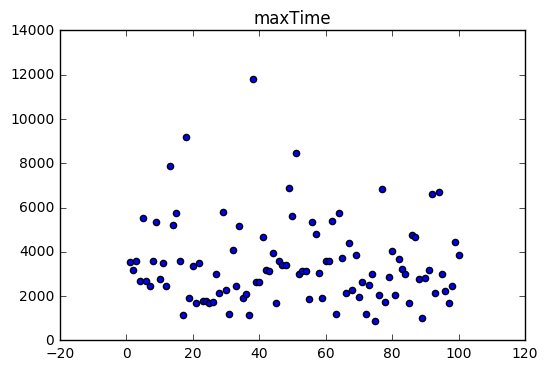

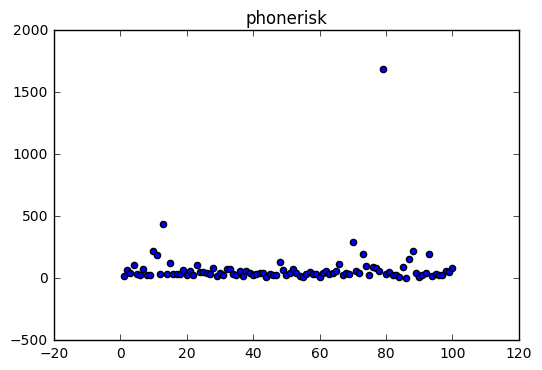

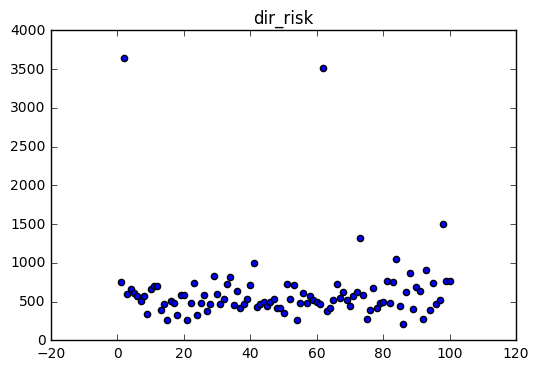

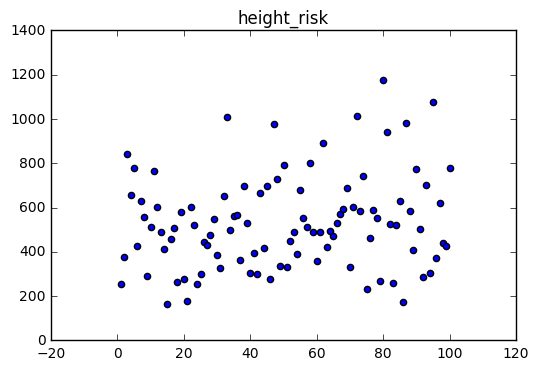

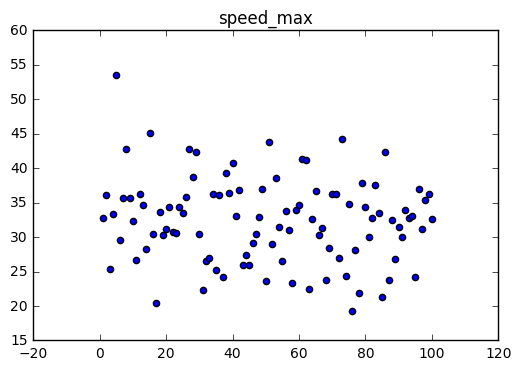

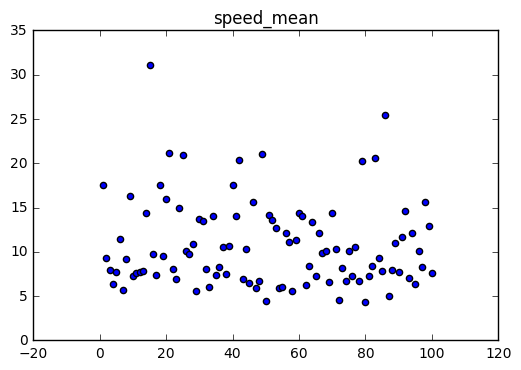

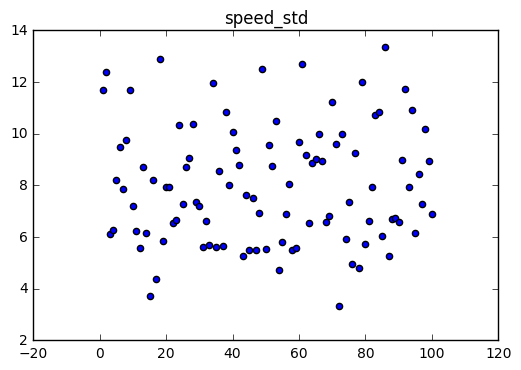

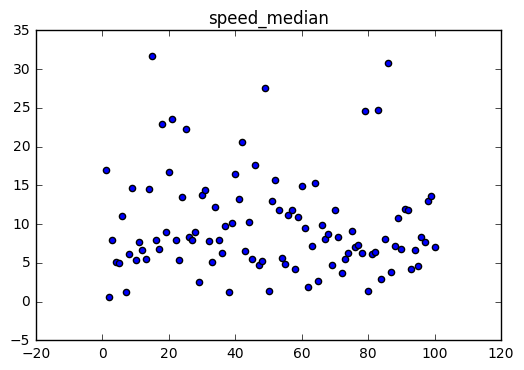

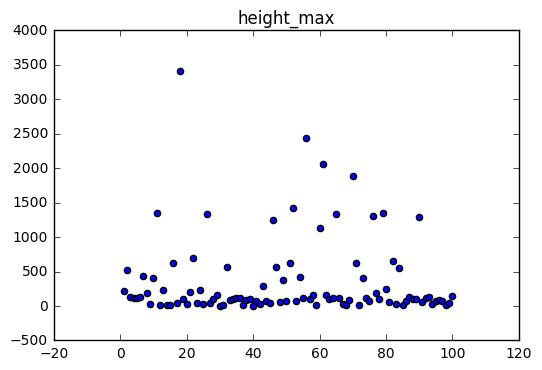

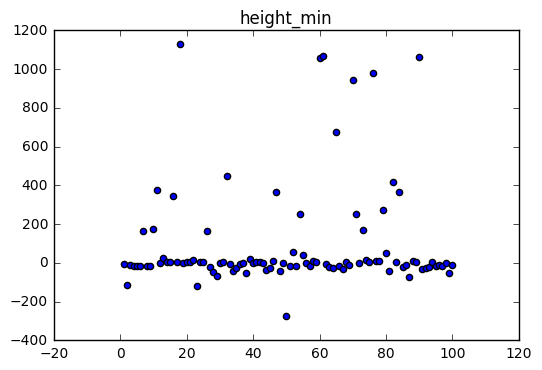

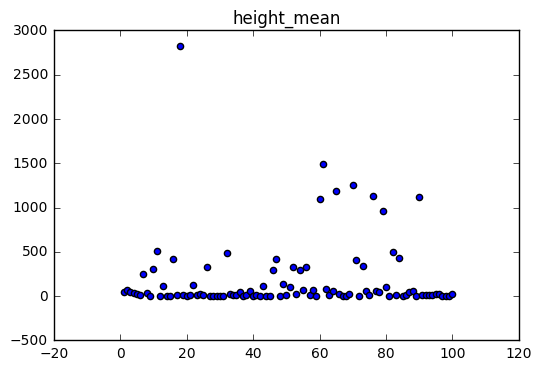

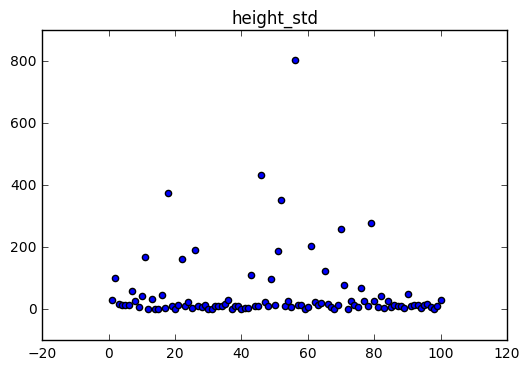

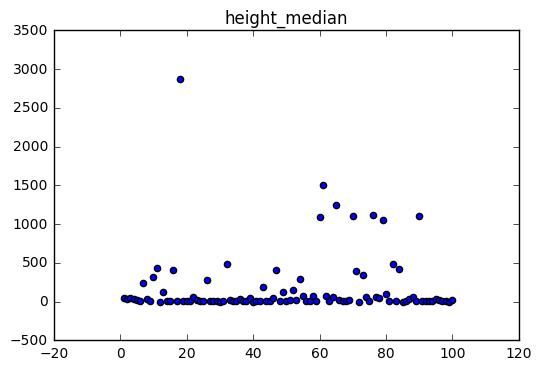

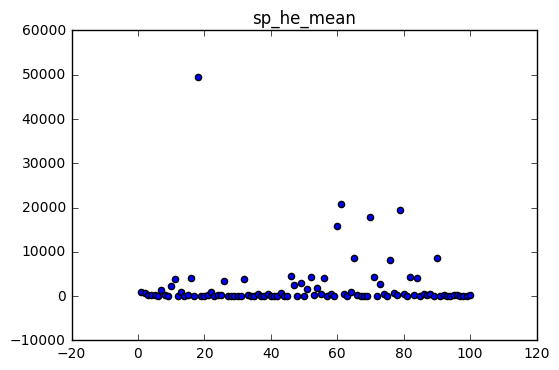

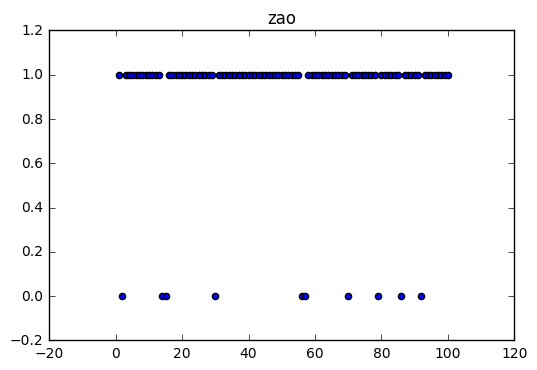

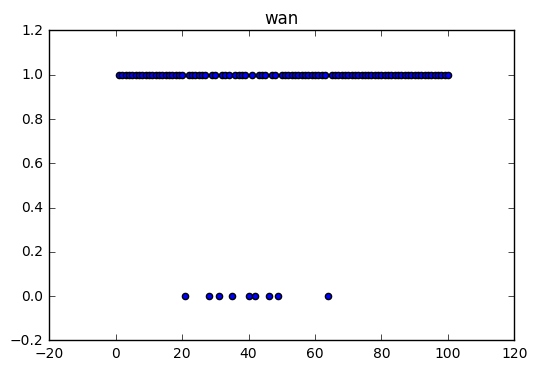

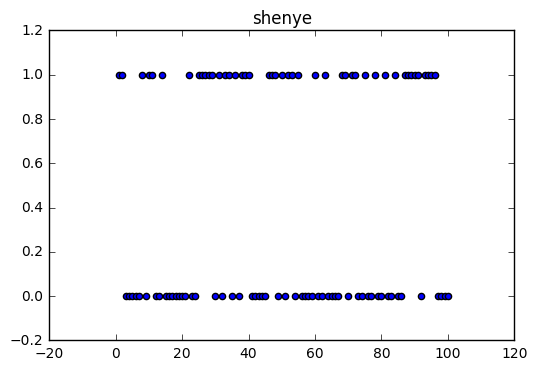

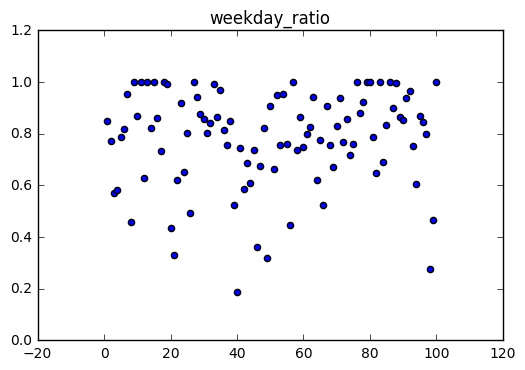

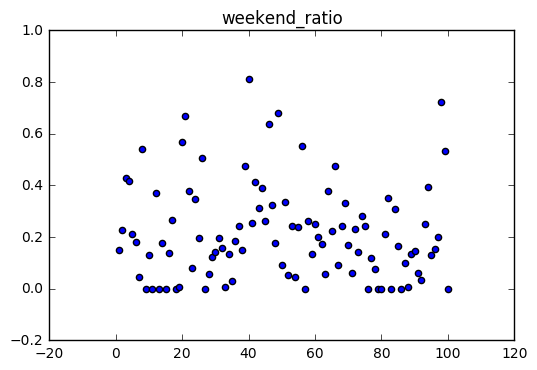

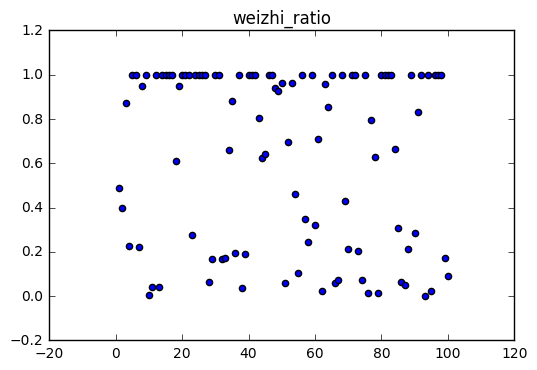

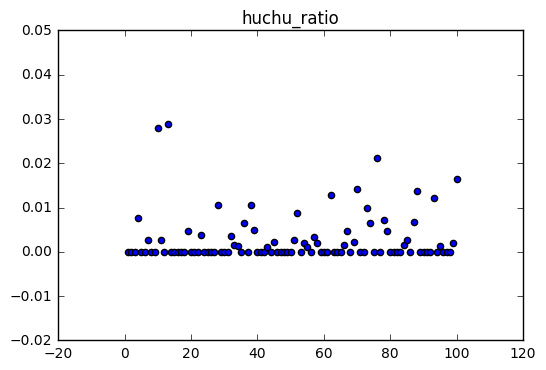

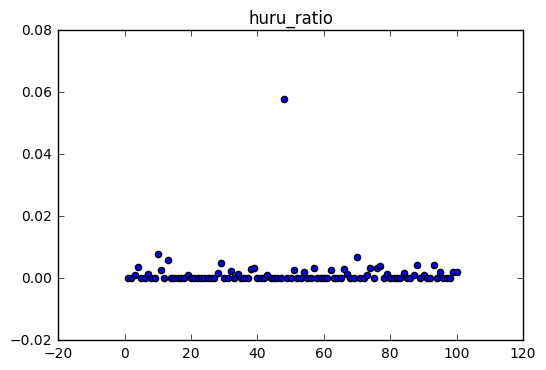

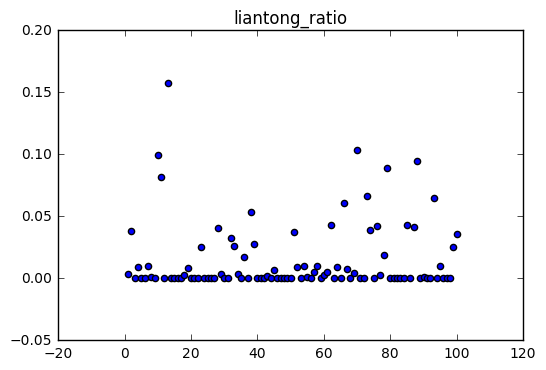

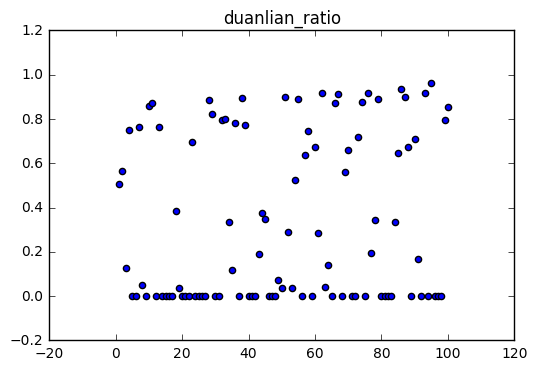

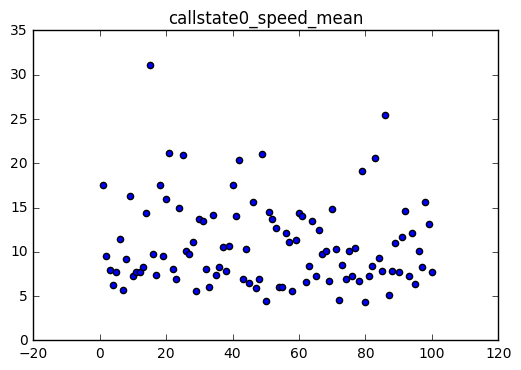

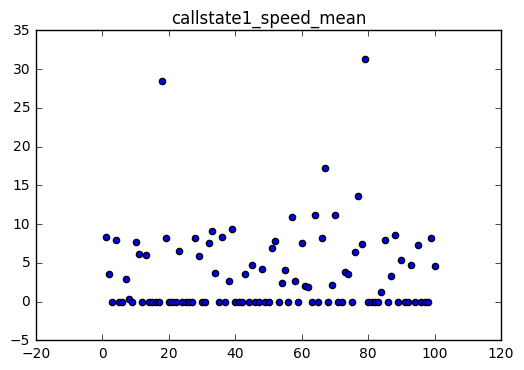

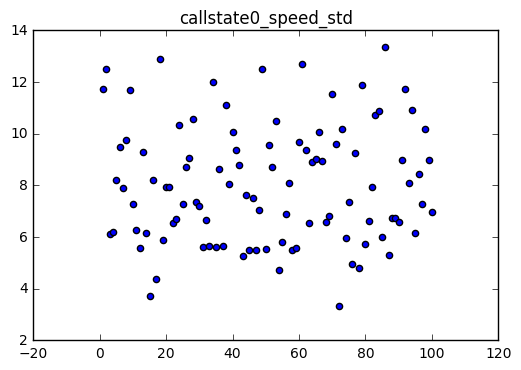

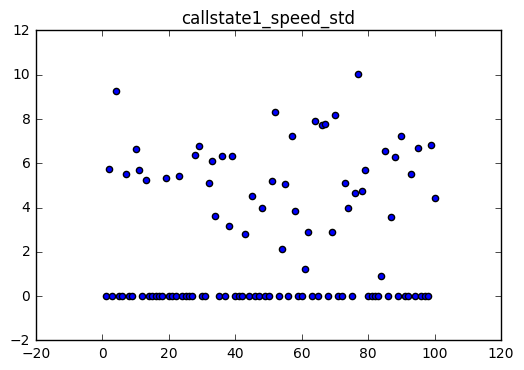

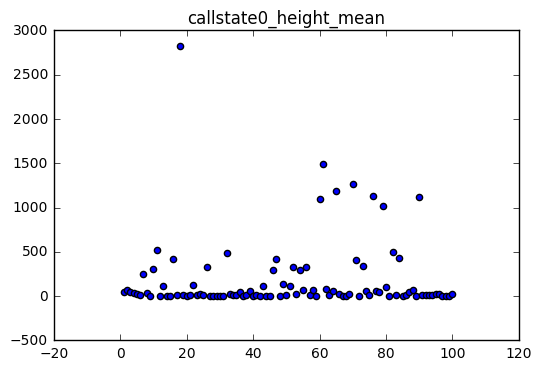

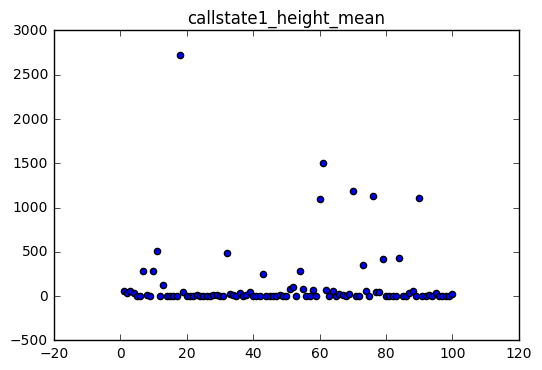

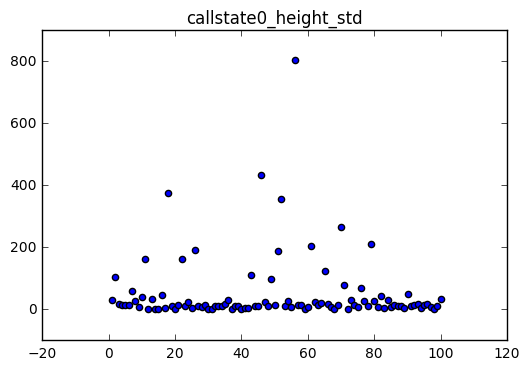

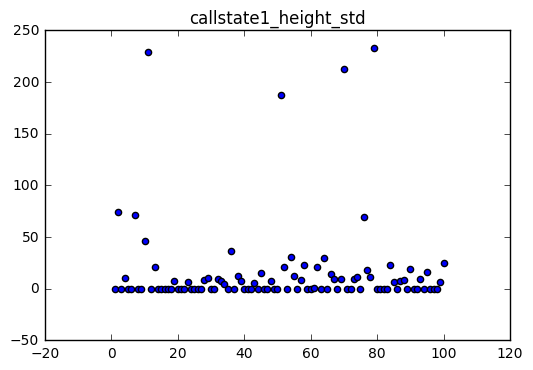

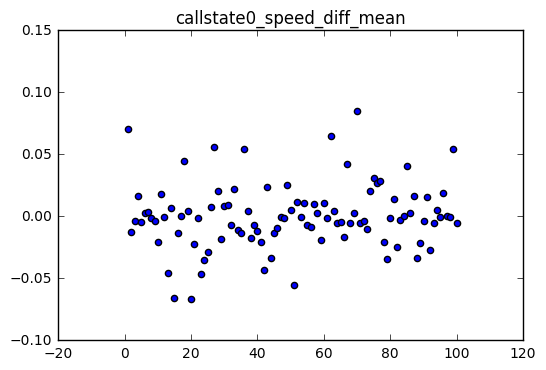

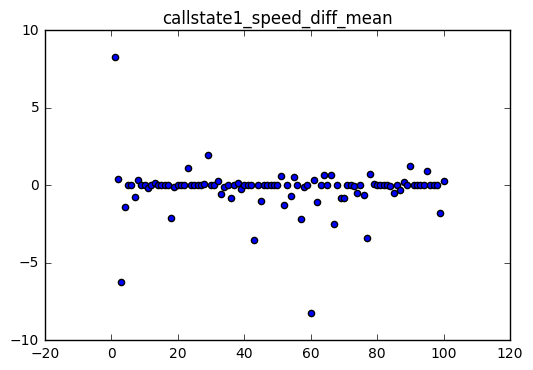

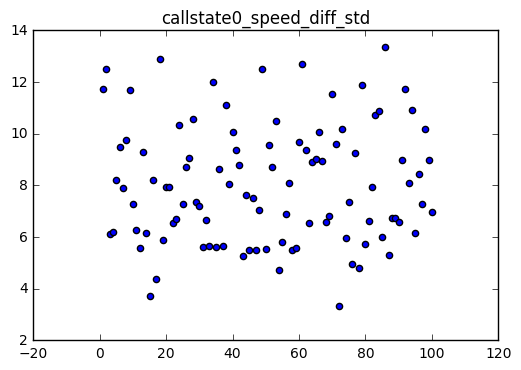

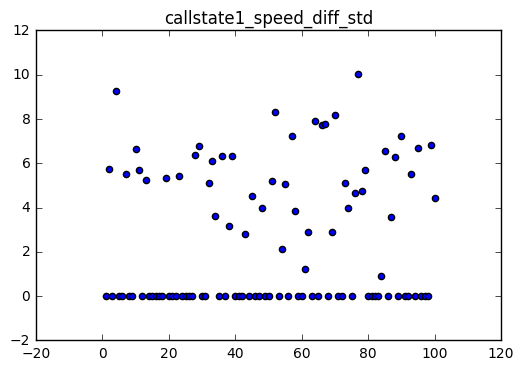

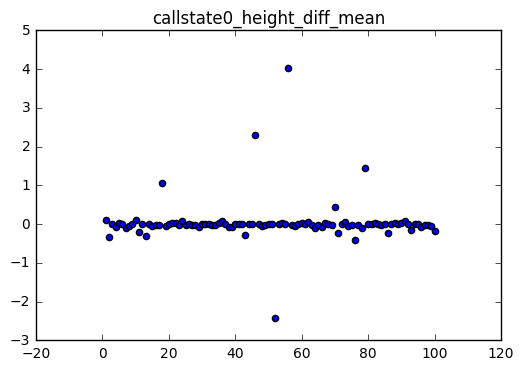

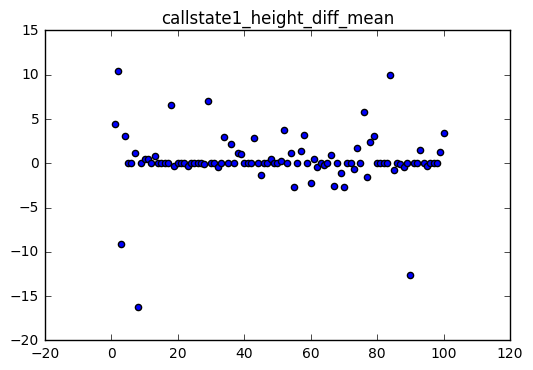

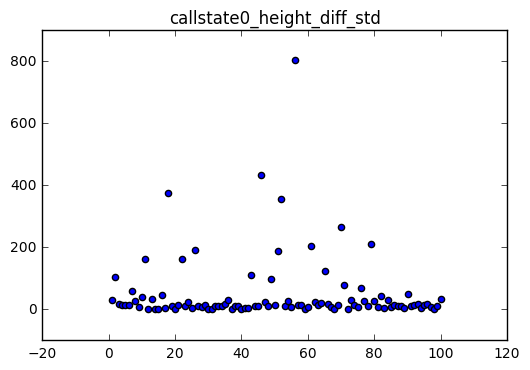

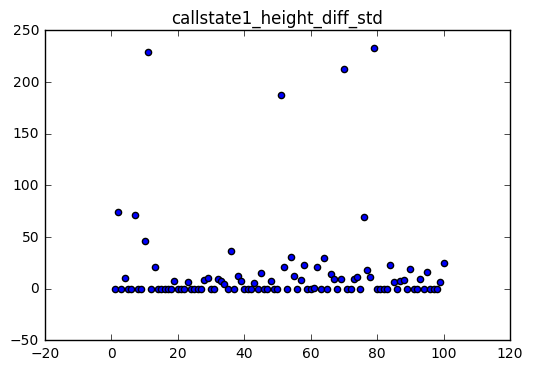

In [12]:
x = feature_train.loc[:,'p_id']
# y = feature_train.loc[:,'height_max']
# plt.scatter(x,y)
# plt.show()
feature_name = list(feature_train.columns)
for index,name in enumerate(feature_name[1:]):
    plt.figure(index)
    y = feature_train.loc[:,name]
    plt.scatter(x,y)
    plt.title(name)
plt.show()